In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [8]:
#data = pd.read_csv("datasets/ds_texto.csv")
#data = pd.read_csv("datasets/ds_full.csv")
#data = pd.read_csv("datasets2/ds_texto.csv")
#data = pd.read_csv("datasets2/ds_full.csv")
#data = pd.read_csv("datasets2/ds_full_em.csv")
#data = pd.read_csv("datasets/ds_full_em.csv")
#data = pd.read_csv("datasets/ds_texto_concat.csv")
data = pd.read_csv("datasets2/ds_texto_concat.csv")

data.head()

,id,rotulo,MAIUSCULAS,EXCLAMA,ASPAS,POL_ABSOLUTO,funct,pronoun,ppron,i,...,negate,verb,adj,interrog,affect,posemo,negemo,anx,anger,sad
0,53,FALSO,0.185105,0.0,0.0,0.500000,0.488384,0.419191,0.230473,0.237002,...,0.104996,0.324418,0.373536,0.104918,0.348045,0.078747,0.441619,0.245902,0.000000,0.0
1,1136,VERDADE,0.097101,0.0,0.0,0.333333,0.428923,0.321148,0.138170,0.000000,...,0.220311,0.534851,0.065315,0.660442,0.426006,0.082617,0.555985,0.000000,0.186732,0.0
2,695,FALSO,0.409534,0.0,0.0,0.500000,0.493180,0.454024,0.145687,0.000000,...,0.000000,0.102536,0.275475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,3312,VERDADE,0.122886,0.0,0.0,0.583333,0.356806,0.196390,0.104917,0.000000,...,0.000000,0.246138,0.264511,0.111443,0.246460,0.083644,0.281450,0.000000,0.000000,0.0
4,1314,VERDADE,0.000000,0.0,0.0,0.500000,0.522131,0.277393,0.115869,0.000000,...,0.000000,0.271833,0.146062,0.492308,0.068047,0.092376,0.000000,0.000000,0.000000,0.0


In [9]:
X = data.drop('id', axis=1)
X = X.drop('rotulo', axis=1)
y = data['rotulo']

In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

### SMOTE dataset pq ele é desbalanceado
over = SMOTE(sampling_strategy=1, random_state= 109)
under = RandomUnderSampler(sampling_strategy=1, random_state= 109)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

print('Original dataset:', Counter(y))

X, y = pipeline.fit_resample(X, y)

print('Resampled dataset:', Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Original dataset: Counter({'VERDADE': 613, 'FALSO': 379})
Resampled dataset: Counter({'FALSO': 613, 'VERDADE': 613})


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[148  38]
 [ 56 126]]
              precision    recall  f1-score   support

       FALSO       0.73      0.80      0.76       186
     VERDADE       0.77      0.69      0.73       182

    accuracy                           0.74       368
   macro avg       0.75      0.74      0.74       368
weighted avg       0.75      0.74      0.74       368



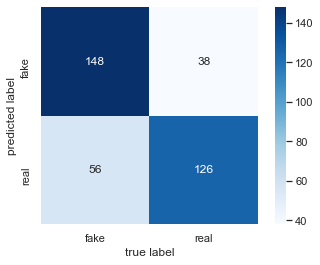

In [12]:
# use seaborn plotting defaults
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues", cbar=True,
            xticklabels=['fake','real'],
            yticklabels=['fake','real'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## Validação Cruzada

In [13]:
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# dfcv = pd.read_csv("datasets/ds_full_validacao_pt.csv")

# Xcv = dfcv.drop('rotulo', axis=1)
# Ycv = dfcv['rotulo']

Xcv = X
Ycv = y

# print('Original dataset:', Counter(Ycv))
# Xcv, Ycv = pipeline.fit_resample(Xcv, Ycv)
# print('Resampled dataset:', Counter(Ycv))


k_folds = StratifiedKFold(n_splits=10, random_state=109, shuffle=True)

scores = cross_val_score(model, Xcv, Ycv, cv=k_folds, scoring='accuracy',n_jobs=-1, verbose=False)
print("Accuracy: %0.4f (+/- %0.4f) "% (scores.mean(), scores.std()))

auc = cross_val_score(model, Xcv, Ycv,  cv=k_folds, scoring = 'roc_auc')
print("AUC: %0.4f (+/- %0.4f) "% (auc.mean(), auc.std()))

#total_preds = model.predict(Xcv)

#Transforma para 0 e 1
encoder = LabelEncoder()
encoder.fit(Ycv)
encoded_Y = encoder.transform(Ycv)

f1 = cross_val_score(model, Xcv, encoded_Y, cv=k_folds, scoring='f1', n_jobs=-1, verbose=False)
print("F1: %0.4f (+/- %0.4f) "% (f1.mean(), f1.std()))

Accuracy: 0.7194 (+/- 0.0397) 
AUC: 0.7707 (+/- 0.0356) 
F1: 0.6820 (+/- 0.0175) 


## Matriz de Confusão K-Fold

[[444 169]
 [178 435]]
              precision    recall  f1-score   support

       FALSO       0.71      0.72      0.72       613
     VERDADE       0.72      0.71      0.71       613

    accuracy                           0.72      1226
   macro avg       0.72      0.72      0.72      1226
weighted avg       0.72      0.72      0.72      1226



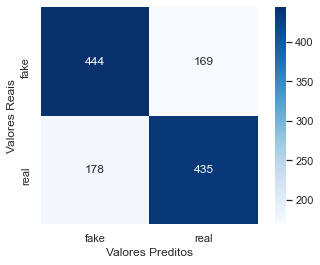

In [8]:
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(model, Xcv, Ycv, cv=k_folds)
mat_cv = confusion_matrix(Ycv, y_pred_cv)

print(mat_cv)
print(classification_report(Ycv, y_pred_cv))

sns.heatmap(mat_cv, square=True, annot=True, fmt='d', cmap="Blues", cbar=True,
            xticklabels=['fake','real'],
            yticklabels=['fake','real'])
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais');

## Curva ROC K-Fold

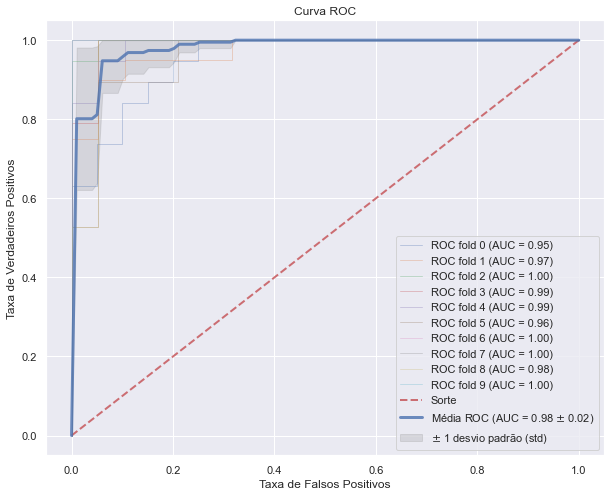

In [9]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Trabalha o Dataset Para poder ser printado
Xcv = X
Ycv = y
scaler = MinMaxScaler().fit(Xcv)
Xcv = scaler.transform(Xcv)

encoder = LabelEncoder()
encoder.fit(Ycv)
Ycv = encoder.transform(Ycv)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i,(train, test) in enumerate(k_folds.split(Xcv, Ycv)):
    model.fit(Xcv[train], Ycv[train])
    viz = plot_roc_curve(model, Xcv[test], Ycv[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Sorte', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
       label=r'Média ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
       lw=3, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=.2,
                label=r'$\pm$ 1 desvio padrão (std)')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Curva ROC")
ax.legend(loc=0)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()